In [17]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.robotparser import RobotFileParser
from requests.compat import urlparse, urljoin
from requests.exceptions import HTTPError
import matplotlib.pyplot as plt
import re
import cv2
import os
import urllib
import numpy as np
import pandas as pd
import sqlite3
from math import sin, cos, sqrt, atan2, radians

headers = {'user-agent':"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36"}

def canfetch(url, agent='*', path='/'):
    robot = RobotFileParser(urljoin(url, '/robots.txt'))
    robot.read()
    return robot.can_fetch(agent, urlparse(url)[2])
    
def download(url, params={}, headers={}, method='GET', limit=3):
    method = method.upper()
    if canfetch(url) == False:
        print('[Error] ' + url)
    else: 
        try:
            resp = requests.request(method, url,
                   params=params if method=='GET' else {},
                   data=params if method=='POST' else {},
                   headers=headers)
            resp.raise_for_status()
        except HTTPError as e:
            if limit > 0 and e.response.status_code >= 500: # 500 에러 재귀 ;너무많은 트래픽 안생기도록
                print(limit)
                time.sleep(300) 
                resp = download(url, params, headers, method, limit-1)
            else:
                print('[{}] '.format(e.response.status_code) + url)
                print(e.response.status_code)
                print(e.response.reason)
                print(e.response.headers)
        return resp
    
    
def mydistance(a1,b1,a2,b2):
    x1 = radians(a1)
    y1 = radians(b1)
    x2 = radians(a2)
    y2 = radians(b2)
    dlon = x2 - x1
    dlat = y2 - y1
    a = sin(dlat / 2)**2 + cos(y1) * cos(y2) * sin(dlon / 2)**2 
    c = 2 * atan2(sqrt(a), sqrt(1 - a))    
    return c


def letterbox(img, new_shape=(240, 320), color=(114, 114, 114)):
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

    ratio = r, r  
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  
    # minimum rectangle
    dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

def labelvs(k):
    if k <200:
        a = 'Dense'
    elif k < 1000:
        a = 'Shallow'
    else:
        a = 'None'
    return a

def weatherlabel(rain, fog):
    if rain != 0:
        return '비'
    elif fog == 'Dense' or fog == 'Shallow' :
        return '안개'
    else:
        return '맑음'
    

def sunnylabel(k):
    if k == '맑음':
        return 1
    return 0

In [6]:
from datetime import date, timedelta

yesterday = date.today() - timedelta(1)
yesterday = yesterday.strftime('%Y%m%d')
yesterday = ['2020110207','2020110217']

In [2]:
data = pd.read_csv('CCTV.csv',encoding='CP949')
AWS = pd.read_csv('AWS_measure.csv', encoding='CP949')

In [125]:
def download(url, params={}, headers={}, method='GET', limit=3):
    method = method.upper()
    if canfetch(url) == False:
        print('[Error] ' + url)
#     else: #bot 접근 못하게 막은데있어어 else뺌
        try:
            resp = requests.request(method, url,
                   params=params if method=='GET' else {},
                   data=params if method=='POST' else {},
                   headers=headers)
            resp.raise_for_status()
        except HTTPError as e:
            if limit > 0 and e.response.status_code >= 500: # 500 에러 재귀 ;너무많은 트래픽 안생기도록
                print(limit)
                time.sleep(300) # => random, 1초에 1번
                resp = download(url, params, headers, method, limit-1)
            else:
                print('[{}] '.format(e.response.status_code) + url)
                print(e.response.status_code)
                print(e.response.reason)
                print(e.response.headers)
        return resp
    

servicekey = 'yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D'
# url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'
url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList?serviceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&ServiceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&numOfRows=100&dataType=JSON&dataCd=ASOS&dateCd=HR&startDt='+today[:-2]+'&startHh=01&endDt='+today[:-2]+'&endHh=23&stnIds='

con = sqlite3.connect("meta_aws.db")

cur = con.cursor()
query = cur.execute('select * from meta_asos')
cols = [column[0] for column in query.description]
rr = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
cur.close()
con.close()

asos = pd.DataFrame()
for _ in rr['지점']:
    resp=download(url + str(_),headers = headers,method = 'GET')
    result= resp.json()
    asos_ = pd.DataFrame.from_dict(result['response']['body']['items']['item'])
    asos_ = asos_[['stnNm','tm','vs','stnId']]
    asos = pd.concat([asos,asos_])
asos.reset_index(drop=True, inplace=True)
asos['vs'] = asos['vs'].astype('int')

[Error] http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList?serviceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&ServiceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&numOfRows=100&dataType=JSON&dataCd=ASOS&dateCd=HR&startDt=20201102&startHh=01&endDt=20201102&endHh=23&stnIds=98
[Error] http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList?serviceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&ServiceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&numOfRows=100&dataType=JSON&dataCd=ASOS&dateCd=HR&startDt=20201102&startHh=01&endDt=20201102&endHh=23&stnIds=99
[Error] http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList?serviceKey=yZzD%2BV9ZD4mghiOjsejpcg37tA2iS86bBY7vs6iCZLXqzC4S%2Fl9U48LbKMDx53q0tqzYXYXoyGuOA7t3tllg9g%3D%3D&Servi

In [126]:
asos['fog'] = asos['vs'].map(lambda x : labelvs(x))
ASOS = pd.merge(asos, rr, left_on='stnNm', right_on='지점명')[['지점','지점명','tm','fog','위도','경도']]
ASOS['tm'] = pd.to_datetime(ASOS['tm'])
ASOS['tm'] = ASOS['tm'].dt.strftime('%Y%m%d%H')
ASOS = ASOS[ASOS['tm'].str.contains(today)]
ASOS.reset_index(drop=True, inplace=True)

In [127]:
ASOS

,지점,지점명,tm,fog,위도,경도
0,98,동두천,2020110217,None,37.9019,127.0607
1,99,파주,2020110217,None,37.8859,126.7665
2,102,백령도,2020110217,None,37.9740,124.7124
3,108,서울,2020110217,None,37.5714,126.9658
4,112,인천,2020110217,None,37.4777,126.6249
5,119,수원,2020110217,None,37.2575,126.9830
6,201,강화,2020110217,None,37.7074,126.4463
7,202,양평,2020110217,None,37.4886,127.4945
8,203,이천,2020110217,None,37.2640,127.4842


In [124]:
today = '2020110217'
data = pd.read_csv('CCTV.csv',encoding='CP949')

In [128]:
def download(url, params={}, headers={}, method='GET', limit=3):
    method = method.upper()
    if canfetch(url) == False:
        print('[Error] ' + url)
    else: #bot 접근 못하게 막은데있어어 else뺌
        try:
            resp = requests.request(method, url,
                   params=params if method=='GET' else {},
                   data=params if method=='POST' else {},
                   headers=headers)
            resp.raise_for_status()
        except HTTPError as e:
            if limit > 0 and e.response.status_code >= 500: # 500 에러 재귀 ;너무많은 트래픽 안생기도록
                print(limit)
                time.sleep(300) # => random, 1초에 1번
                resp = download(url, params, headers, method, limit-1)
            else:
                print('[{}] '.format(e.response.status_code) + url)
                print(e.response.status_code)
                print(e.response.reason)
                print(e.response.headers)
        return resp
    

url = 'https://www.weather.go.kr/cgi-bin/aws/nph-aws_txt_min_guide_test?'+ today +'00&MINDB_01M&0&m&K'
resp=download(url,  headers = headers,method= 'POST')
dom = BeautifulSoup(resp.content, 'lxml')
k =pd.read_html(str(dom.find('table')),header=0)
today_weather = k[1][['AWS 지점 / 고도','AWS 지점 / 고도.1','강수','강수15','위치']]
today_weather['강수15'].replace('.','0',inplace=True)
today_weather['강수15'] = today_weather['강수15'].astype('float')

con = sqlite3.connect("meta_aws.db")
cur = con.cursor()
query = cur.execute('select * from test')
cols = [column[0] for column in query.description]
ee = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
cur.close()
con.close()

AWS = pd.merge(today_weather,ee,left_on='AWS 지점 / 고도.1',right_on='지점명')[['AWS 지점 / 고도','AWS 지점 / 고도.1','강수','강수15','위치','위도','경도']]
AWS.to_csv(today + '/AWS.csv',index=False,encoding='CP949')

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\pandas\core\series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
data['AWS 지점'] = ''
data['ASOS 지점'] = ''
num = 0
for i,j in zip(data['coordx'],data['coordy']):
    distance = pd.Series(AWS[['위도','경도']].apply (lambda row: mydistance(i,j,row['경도'],row['위도']), axis=1))
    data.loc[num,'AWS 지점'] = AWS.loc[np.argmin(distance),'AWS 지점 / 고도.1']
    distance = pd.Series(ASOS[['위도','경도']].apply (lambda row: mydistance(i,j,row['경도'],row['위도']), axis=1))
    data.loc[num,'ASOS 지점'] = ASOS.loc[np.argmin(distance),'지점명']
    num+=1
    
data = pd.merge(data,AWS,left_on = 'AWS 지점',right_on = 'AWS 지점 / 고도.1')
data = pd.merge(data,ASOS[ASOS['tm']==today],left_on = 'ASOS 지점',right_on = '지점명')
data['weather'] = data.apply(lambda x : weatherlabel(x['강수15'],x['fog']),axis=1)
data['sunny'] = data['weather'].map(lambda x : sunnylabel(x))
data1 = data[['cctvname','coordy','coordx','강수15','fog','weather','sunny']]
data1['cctvdir'] = today +'/'+ data1['cctvname'] + '.mp4'
data1.head()

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,cctvname,coordy,coordx,강수15,fog,weather,sunny,cctvdir
0,[수도권제1순환선] 판교분기점2,37.406650,127.09706,0.0,None,맑음,1,2020110217/[수도권제1순환선] 판교분기점2.mp4
1,[수도권제1순환선] 청계운중교,37.394720,127.06944,0.0,None,맑음,1,2020110217/[수도권제1순환선] 청계운중교.mp4
2,[경부선] 죽전휴게소(서울),37.332780,127.10361,0.0,None,맑음,1,2020110217/[경부선] 죽전휴게소(서울).mp4
3,[경부선] 서울영업소,37.365560,127.10250,0.0,None,맑음,1,2020110217/[경부선] 서울영업소.mp4
4,[경부선] 판교2,37.399693,127.10043,0.0,None,맑음,1,2020110217/[경부선] 판교2.mp4


In [130]:
data1.to_csv(today + '.csv',index=False,encoding='CP949')

In [131]:
data2 = pd.read_csv(today+'.csv',encoding='CP949')
data2

,cctvname,coordy,coordx,강수15,fog,weather,sunny,cctvdir
0,[수도권제1순환선] 판교분기점2,37.406650,127.097060,0.0,None,맑음,1,2020110217/[수도권제1순환선] 판교분기점2.mp4
1,[수도권제1순환선] 청계운중교,37.394720,127.069440,0.0,None,맑음,1,2020110217/[수도권제1순환선] 청계운중교.mp4
2,[경부선] 죽전휴게소(서울),37.332780,127.103610,0.0,None,맑음,1,2020110217/[경부선] 죽전휴게소(서울).mp4
3,[경부선] 서울영업소,37.365560,127.102500,0.0,None,맑음,1,2020110217/[경부선] 서울영업소.mp4
4,[경부선] 판교2,37.399693,127.100430,0.0,None,맑음,1,2020110217/[경부선] 판교2.mp4
...,...,...,...,...,...,...,...,...
560,[제2외곽순환선] 대곶IC,37.647724,126.603200,0.0,None,맑음,1,2020110217/[제2외곽순환선] 대곶IC.mp4
561,[제2외곽순환선] 서김포통진IC,37.674873,126.634834,0.0,None,맑음,1,2020110217/[제2외곽순환선] 서김포통진IC.mp4
562,[구리포천선] 동의정부IC북측,37.736042,127.117340,0.0,None,맑음,1,2020110217/[구리포천선] 동의정부IC북측.mp4
563,[구리포천선] 의정부휴게소(구리),37.740444,127.119250,0.0,None,맑음,1,2020110217/[구리포천선] 의정부휴게소(구리).mp4


In [ ]:
today = '2020102612'

In [48]:
cctvdir = [k for k in os.listdir(today) if k.endswith('mp4')]
n = len(cctvdir)
imgs = [None]*n
for i , _ in enumerate(cctvdir):
    img = [None]*10
    cap = cv2.VideoCapture(today + '/' + _)
    assert cap.isOpened(), 'Failed to open %s' % _
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    for j in range(10):
        ret, image = cap.read()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img[j] = gray
    s = np.stack([letterbox(x)[0] for x in img], 0) 
    imgs[i] = s

In [133]:
AWS[['AWS 지점 / 고도.1','강수','강수15','위도','경도']]

,AWS 지점 / 고도.1,강수,강수15,위도,경도
0,관악(레),○,0.0,37.4453,126.9640
1,용문산,○,0.0,37.5455,127.6113
2,강남,○,0.0,37.4982,127.0816
3,서초,○,0.0,37.4846,127.0260
4,강동,○,0.0,37.5555,127.1450
...,...,...,...,...,...
86,무의도,○,0.0,37.3904,126.4252
87,백학,○,0.0,38.0404,126.9245
88,현충원,○,0.0,37.5004,126.9765
89,풍도,-,0.0,37.1161,126.3856


In [190]:
def imwrite(filename, img, params=None): 
    try: 
        ext = os.path.splitext(filename)[1] 
        result, n = cv2.imencode(ext, img, params) 
        if result: 
            with open(filename, mode='w+b') as f: 
                n.tofile(f) 
                return True 
        else: 
            return False 
    except Exception as e: 
        print(e) 
        return False

In [196]:
from tqdm import tqdm
import math

for i in tqdm(range(all_data.shape[0])):
    count = 0
    videoFile = all_data['cctvdir'][i]
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=0
    while(cap.isOpened()):
        x+=1
        if x%3==1: 
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                filename ='cctv_aws/image/' + videoFile.split('/')[0] + '_' + videoFile.split('/')[1][:-4]+'_frame'+str(count)+'.jpg'
                count+=1
                imwrite(filename, frame)
    cap.release()

100%|██████████████████████████████████████████████████████████████████████████████| 6215/6215 [10:45<00:00,  9.63it/s]


In [188]:
img = [None]*10
cap = cv2.VideoCapture(videoFile)
assert cap.isOpened(), 'Failed to open %s' % _
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
for j in range(5):
    ret, image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img[j] = gray
s = np.stack([letterbox(x)[0] for x in img], 0) 
imgs[i] = s

AttributeError: 'NoneType' object has no attribute 'shape'

In [170]:
all_data = pd.DataFrame()

for _ in os.listdir('cctv_aws/csv'):
    da = pd.read_csv('cctv_aws/csv/' + _ ,encoding='CP949')
    all_data = pd.concat([all_data,da])
    
all_data.reset_index(drop=True, inplace=True)

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [148]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6215 entries, 0 to 564
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cctvname  6215 non-null   object 
 1   coordy    6215 non-null   float64
 2   coordx    6215 non-null   float64
 3   강수15      6215 non-null   float64
 4   fog       6215 non-null   object 
 5   weather   6215 non-null   object 
 6   sunny     6215 non-null   int64  
 7   cctvdir   6215 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 437.0+ KB


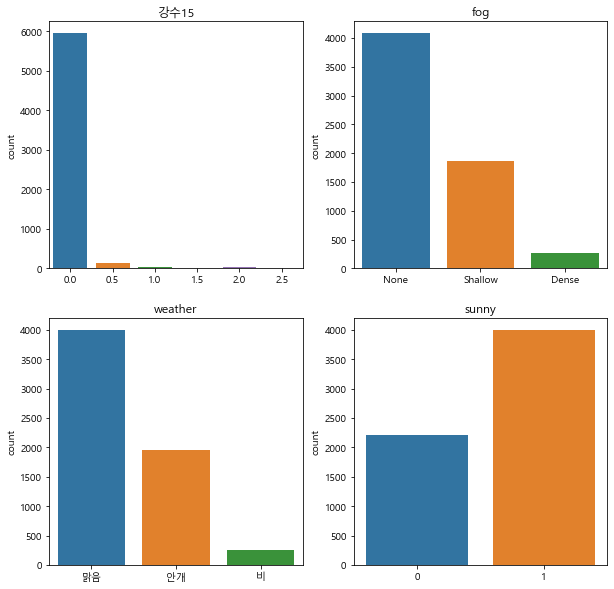

In [166]:
label_col = all_data.columns[3:7]
plt.figure(figsize = (10,10))
for _ , i in enumerate(label_col):
    plt.subplot(2,2, _+1)
    sns.countplot(x = i ,data=all_data)
    plt.title(i)
    plt.xlabel('')